# Kaggle Titanic Challenge

Here is a link to the dataset: https://www.kaggle.com/c/titanic.

## Goal
Apply machine learning to predict which passengers survived the Titanic sinking. 

**My goal is to submit a trained model try to go up the leaderboard.** 

## Overview
**training set: train.csv**

*Shape*: (891, 12)

**testing set: test.csv**

*Shape*: (418, 11)

In [98]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
params = {
    'axes.labelsize': 'large',
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25,7]
}
plt.rcParams.update(params)

In [99]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [100]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [101]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Data Cleaning

First, I will impute the missing values. Then, proceed to pre-processing the data and feature engineering.

--- 

*Survived* is the label I want to predict. 0 means the passenger died, while 1 means they lived.

*PassengerId* will not be used in training, and so can be dropped.

### Imputing the Missing Values - Training

In [102]:
n_missing = train.isnull().sum().sort_values(ascending=False)
percent_missing = train.isnull().sum().sort_values(ascending=False) / len(train)
missing_train = pd.DataFrame(data=[n_missing, percent_missing])
missing_train

,Cabin,Age,Embarked,Fare,Ticket,Parch,SibSp,Sex,Name,Pclass,Survived,PassengerId
0,687.000000,177.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.771044,0.198653,0.002245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


About 19% of the training data is missing *Age*. About 77% is missing *Cabin*, and 2 observations are missing *Embarked*.

#### Imputing Embarked

In [103]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Impute these two observations with the mode of Embarked. 

In [104]:
train.Embarked.fillna('C', inplace=True)

#### Imputing Cabin

Since ~77% of the features are missing, one may consider dropping it. But, having no data on *Cabin* can represent the passenger's low socio-economic status, which may be a factor towards their survival. As such, it is better to impute them.

The observations missing *Cabin* will be imputed with 'N'.
All others will be imputed with the first letter of the *Cabin* variable. 

In [105]:
train.Cabin.fillna('N', inplace=True)

In [106]:
train.Cabin.unique()

array(['N', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [107]:
train.Cabin = [i[0] for i in train.Cabin]

In [108]:
train.Cabin.value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

#### Imputing Age

About 20% of the training observations are missing *Age*. To impute these, I will use Linear Regression to predict these missing values. 

However, this will be done once I engineer more features.

### Imputing the Missing Values - Testing

In [109]:
n_missing = test.isnull().sum().sort_values(ascending=False)
percent_missing = test.isnull().sum().sort_values(ascending=False) / len(train)
missing_test = pd.DataFrame(data=[n_missing, percent_missing])
missing_test

,Cabin,Age,Fare,Embarked,Ticket,Parch,SibSp,Sex,Name,Pclass,PassengerId
0,327.000000,86.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.367003,0.096521,0.001122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


86 of the testing data is missing *Age*. About 36% is missing *Cabin*, and 1 observation is missing *Fare*.

#### Imputing Fare

In [110]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Impute this observation with the mean of passengers who are 'male', *Pclass* of '3', and *Embarked* from 'S'. 

In [111]:
miss_val = test.loc[(test.Sex == 'male') & (test.Pclass == 3) & (test.Embarked == 'S')].Fare.mean()
test.Fare.fillna(miss_val, inplace=True)

#### Imputing Cabin

Perform the same imputation done to the training set to be consistent.

In [112]:
test.Cabin.fillna('N', inplace=True)

In [113]:
test.Cabin.unique()

array(['N', 'B45', 'E31', 'B57 B59 B63 B66', 'B36', 'A21', 'C78', 'D34',
       'D19', 'A9', 'D15', 'C31', 'C23 C25 C27', 'F G63', 'B61', 'C53',
       'D43', 'C130', 'C132', 'C101', 'C55 C57', 'B71', 'C46', 'C116',
       'F', 'A29', 'G6', 'C6', 'C28', 'C51', 'E46', 'C54', 'C97', 'D22',
       'B10', 'F4', 'E45', 'E52', 'D30', 'B58 B60', 'E34', 'C62 C64',
       'A11', 'B11', 'C80', 'F33', 'C85', 'D37', 'C86', 'D21', 'C89',
       'F E46', 'A34', 'D', 'B26', 'C22 C26', 'B69', 'C32', 'B78',
       'F E57', 'F2', 'A18', 'C106', 'B51 B53 B55', 'D10 D12', 'E60',
       'E50', 'E39 E41', 'B52 B54 B56', 'C39', 'B24', 'D28', 'B41', 'C7',
       'D40', 'D38', 'C105'], dtype=object)

In [114]:
test.Cabin = [i[0] for i in test.Cabin]

In [115]:
test.Cabin.value_counts()

N    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin, dtype: int64

In the training set, there is a *Cabin* with the label 'T'. When this is one-hot encoded, I will drop this column from the training set. Keeping it can cause some complications for training the model. 

If the model is trained on features that do not exist in the testing set, then the model can overfit the training set, and cannot generalize to new data. The model will have more variance and less bias.

#### Imputing Age

86 of the testing observations are missing *Age*. To impute these, I will use Linear Regression to predict these missing values. 

However, this will be done once I engineer more features.

### Feature Extraction

*Name* - Extract the title of each passenger. A passenger's title can have an effect on whether or not they survived. For instance, those with the title of *Master* may have been given priority to get on a life boat.

*SibSp* and *Parch* - Can create new features called *NumFamily*. So, for each passenger, the values of *SibSp* and *Parch* will be added + 1 (the 1 represents the passenger themself). 

*Ticket* - More analysis needs to be done for this feature. 

#### Extracting Title from Name

In [116]:
def get_title(i):
    title = i.split(', ')[1].split('.')[0]
    return title

In [117]:
train['Title'] = train.Name.apply(get_title)
test['Title'] = test.Name.apply(get_title)

In [118]:
title_dict = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Ms': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Dr',
    'Rev': 'Rev',
    'Col': 'Officer',
    'Mlle': 'Miss',
    'Major': 'Officer',
    'the Countess': 'Royal',
    'Sir': 'Royal',
    'Capt': 'Officer',
    'Don': 'Royal',
    'Mme': 'Royal',
    'Jonkheer': 'Royal',
    'Lady': 'Royal',
    'Dona': 'Royal'
}

train.Title = train.Title.map(title_dict)
train.drop('Name', axis=1, inplace=True)
test.Title = test.Title.map(title_dict)
test.drop('Name', axis=1, inplace=True)

In [119]:
train.Title.value_counts()

Mr         517
Miss       185
Mrs        125
Master      40
Dr           7
Royal        6
Rev          6
Officer      5
Name: Title, dtype: int64

In [120]:
test.Title.value_counts()

Mr         240
Miss        79
Mrs         72
Master      21
Officer      2
Rev          2
Royal        1
Dr           1
Name: Title, dtype: int64

#### Engineering NumFamily

In [121]:
train['NumFamily'] = train.SibSp + train.Parch + 1
test['NumFamily'] = test.SibSp + test.Parch + 1

#### Analyzing Ticket

In [122]:
train.Ticket.value_counts()

1601                 7
CA. 2343             7
347082               7
347088               6
CA 2144              6
3101295              6
S.O.C. 14879         5
382652               5
347077               4
W./C. 6608           4
LINE                 4
113781               4
349909               4
2666                 4
PC 17757             4
113760               4
19950                4
4133                 4
17421                4
SC/Paris 2123        3
PC 17755             3
347742               3
PC 17582             3
C.A. 31921           3
C.A. 34651           3
239853               3
363291               3
13502                3
35273                3
F.C.C. 13529         3
                    ..
312992               1
345777               1
330959               1
PC 17595             1
A/5 3594             1
113804               1
349244               1
349253               1
2667                 1
STON/O 2. 3101285    1
244310               1
14313                1
349223     

Looking at the unique values, there does not seem to be any reasonable way to distinguish/ clear up the data. There are lots of different levels for *Ticket*, and there is no clear way of pre-processing it. 

One may argue that *Ticket* can represent the socio-economic status of a passenger, which can influence survival. However, this can already be explained by the *Fare*, which is a much more interpretable way of determining the socio-economic status of a passenger.

So, I will drop *Ticket* from both datasets.

In [123]:
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

### Pre-processing

*Pclass* - This is an integer, but is really describing is the social class the passenger belongs in (1st, 2nd, 3rd). One-Hot Encode for each social class level.

*Cabin*, *Embarked*, *Sex* - One-hot encode this. 

*Age* - Use Linear Regression to determine the missing *Age* values.

*PassengerId* - Drop this, since we won't need this in training. 

---

After imputing *Age*, drop *Cabin_T* from the training set. 

In [124]:
train.drop('PassengerId', axis=1, inplace=True)

In [125]:
train = pd.get_dummies(train, columns=['Title','Pclass','Embarked', 'Sex', 'Cabin'])
test = pd.get_dummies(test, columns=['Title','Pclass','Embarked', 'Sex', 'Cabin'])

In [126]:
train.drop('Cabin_T', axis=1, inplace=True)

#### Imputing Age Via Logistic Regression

In [127]:
def impute_age(df):
    temp_test = df.loc[df.Age.isnull()]
    temp_train = df.loc[df.Age.notna()]

    temp_train_X = temp_train.loc[:, 'SibSp':]
    temp_test_X = temp_test.loc[: , 'SibSp':]
    temp_train_y = temp_train.Age
    temp_test_y = temp_test.Age

    logreg = LinearRegression().fit(temp_train_X, temp_train_y)
    preds = logreg.predict(temp_test_X)

    df.loc[df.Age.isnull(), 'Age'] = preds

In [128]:
impute_age(train)
impute_age(test)

## Data Analysis

**After Feature Extraction and Pre-Processing...**

train - Shape: (891,31)

test - Shape: (418, 30)

### Heat-map of the correlation of Top 10 Features on Survived

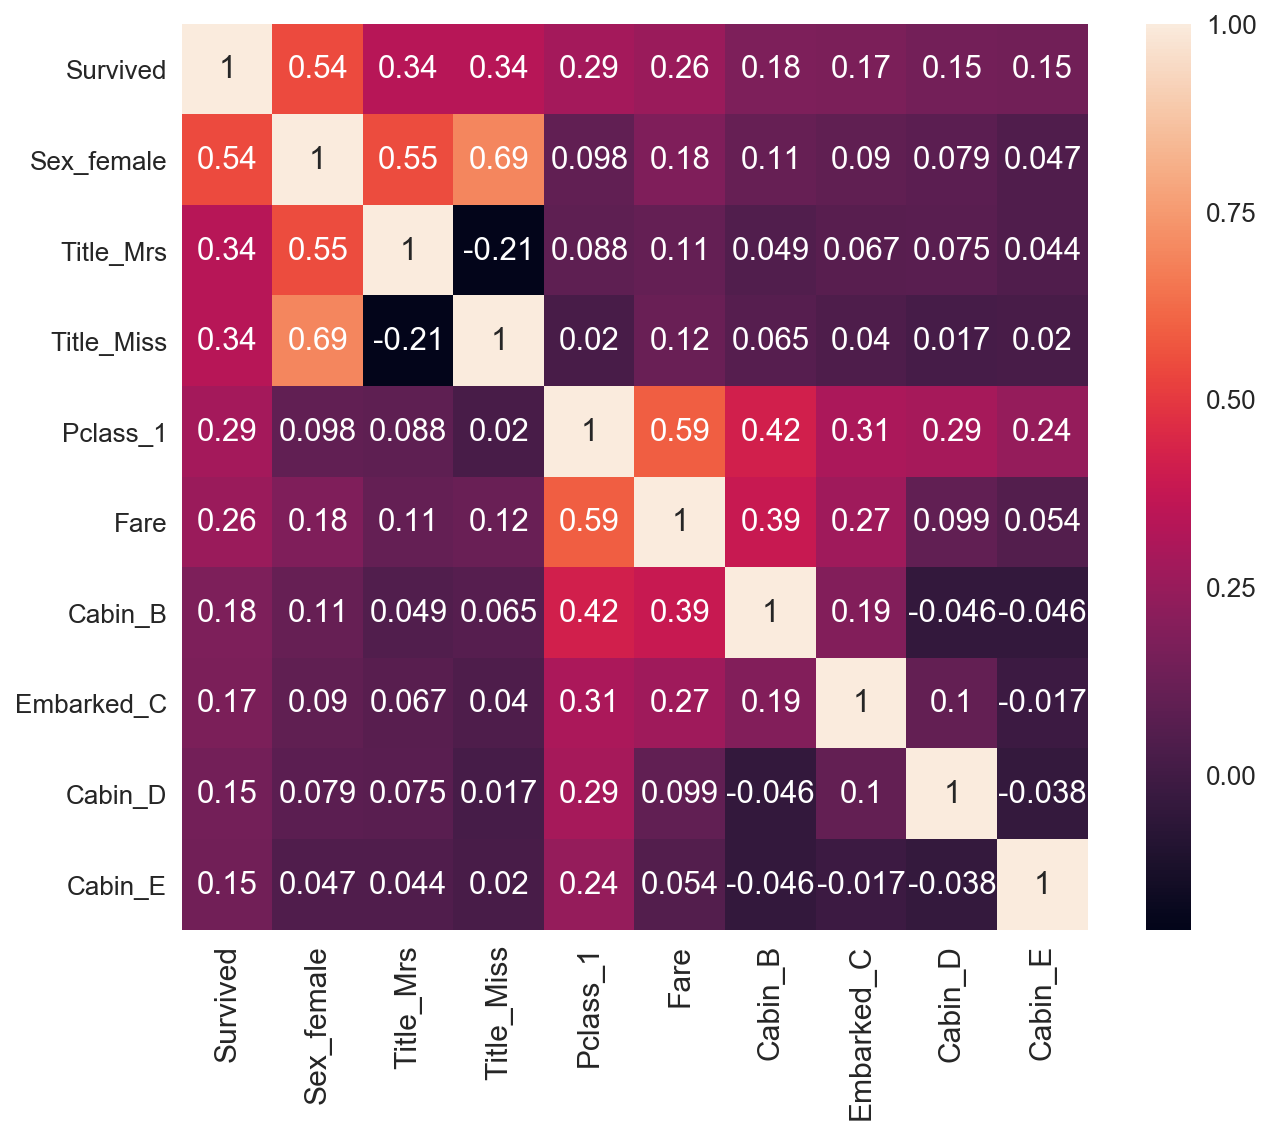

In [129]:
correlation_mat = train.corr(method='pearson')
corr_cols = correlation_mat.nlargest(10, 'Survived')['Survived'].index
correlation_mat = np.corrcoef(train[corr_cols].values.transpose())
f, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.25)
sns.heatmap(correlation_mat, square=True, annot=True, 
            yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

Being a female was correlated relatively strongly with survival. 

### Distribution of Survival on Gender

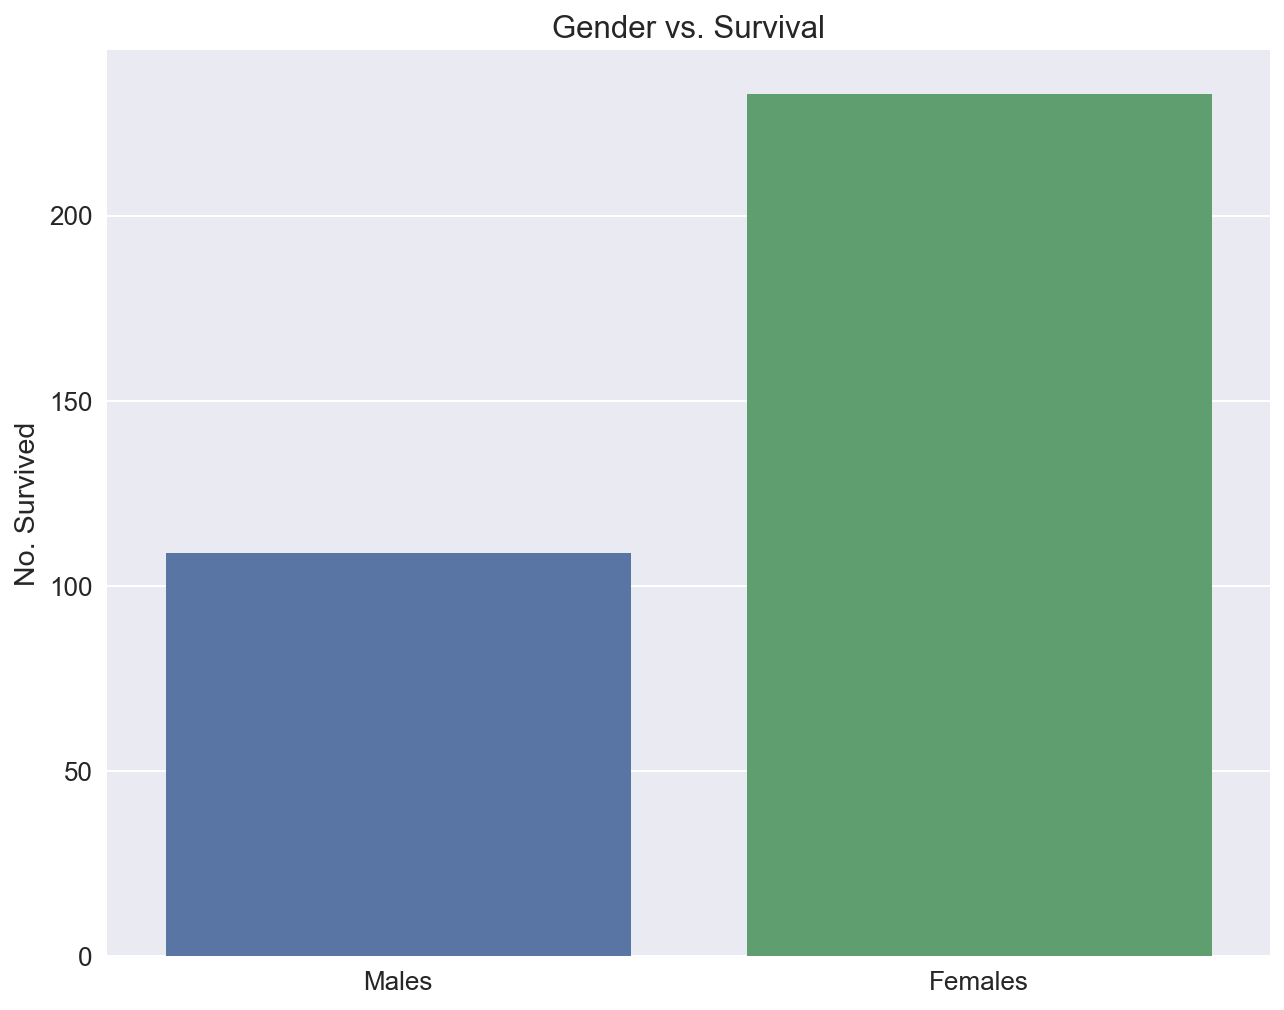

In [130]:
n_females_survived = train[(train['Sex_female'] == 1) & (train['Survived'] == 1)].Sex_female.sum()

n_males_survived = train[(train['Sex_male'] == 1) & (train['Survived'] == 1)].Sex_male.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['Males', 'Females'], y=[n_males_survived, n_females_survived]) 
plt.title('Gender vs. Survival')
plt.ylabel('No. Survived')
plt.show()

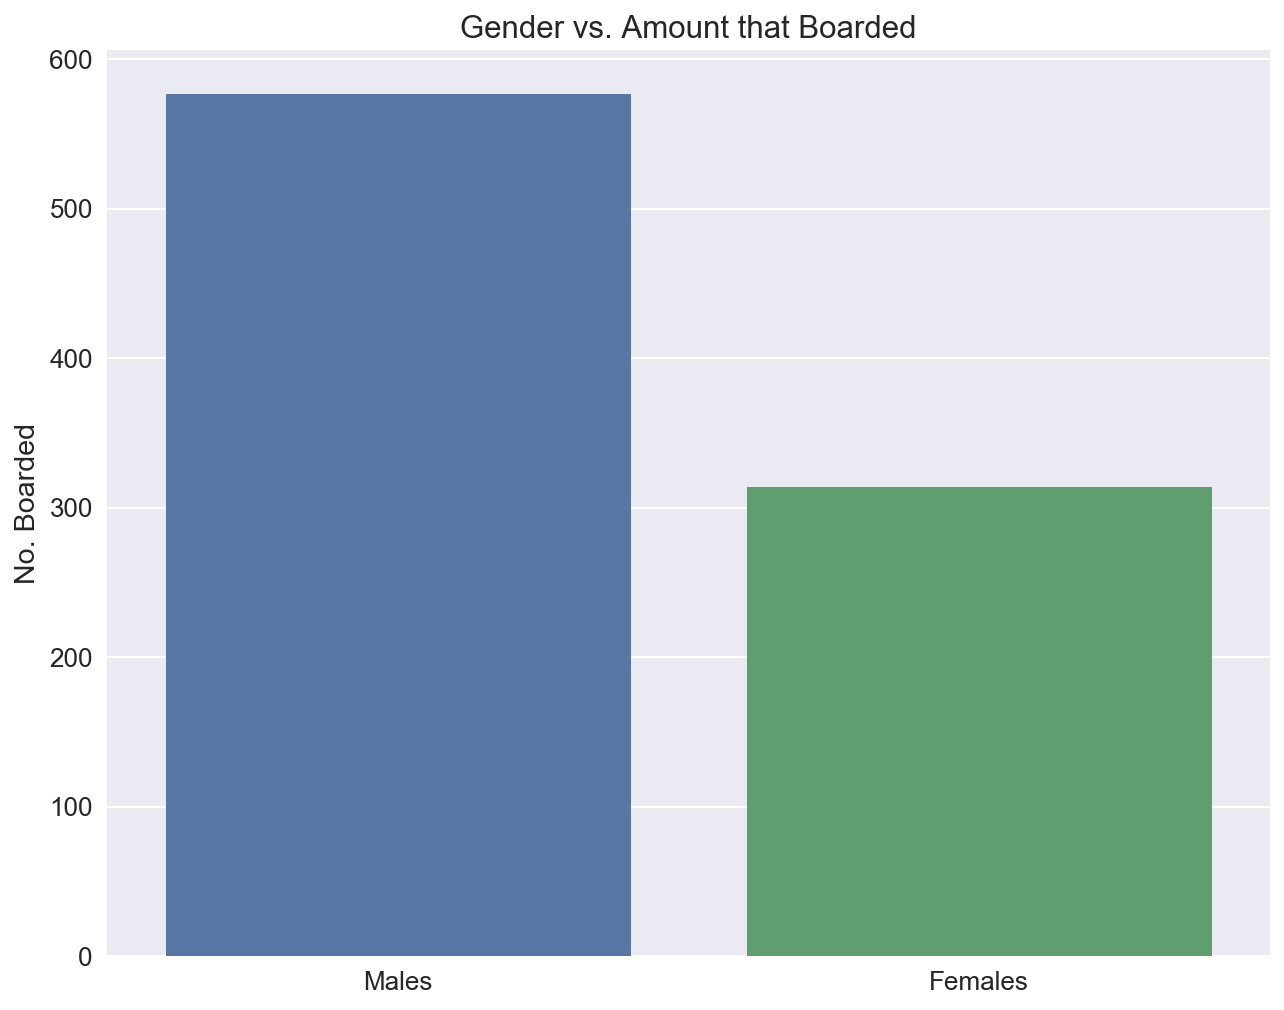

In [131]:
n_total_females = train[(train['Sex_female'] == 1)].Sex_female.sum()
n_total_males = train[(train['Sex_male'] == 1)].Sex_male.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['Males', 'Females'], y=[n_total_males, n_total_females]) 
plt.title('Gender vs. Amount that Boarded')
plt.ylabel('No. Boarded')
plt.show()

In [132]:
print('Percent of Males that Survived: ', n_males_survived / n_total_males)
print('Percent of Females that Survived: ', n_females_survived / n_total_females)

Percent of Males that Survived:  0.18890814558058924
Percent of Females that Survived:  0.7420382165605095


### Distribution of Survival on Pclass

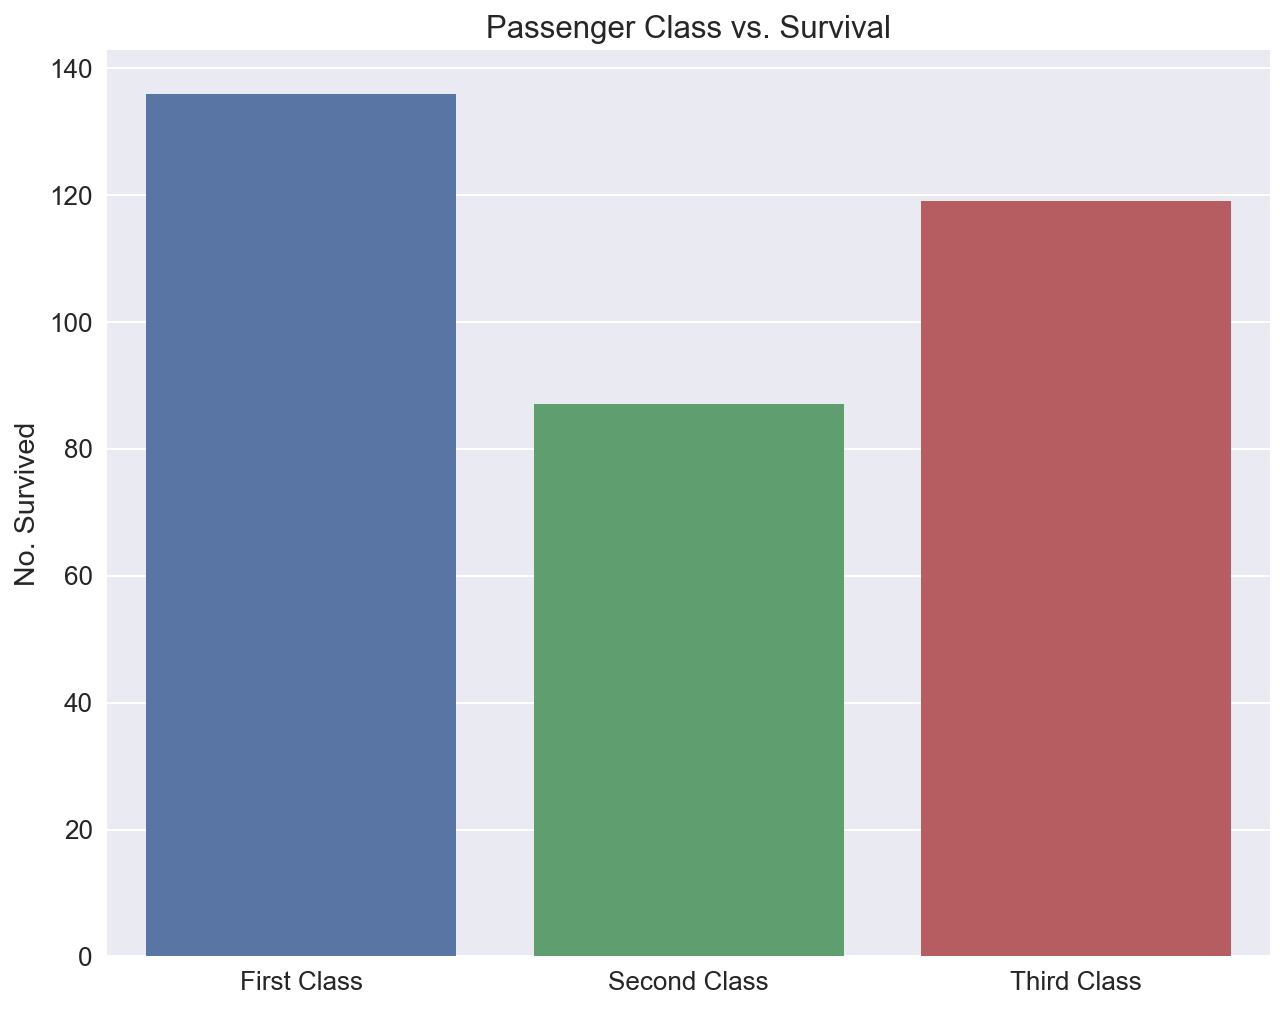

In [133]:
n_firstclass_survived = train[(train['Pclass_1'] == 1) & (train['Survived'] == 1)].Pclass_1.sum()
n_secondclass_survived = train[(train['Pclass_2'] == 1) & (train['Survived'] == 1)].Pclass_2.sum()
n_thirdclass_survived = train[(train['Pclass_3'] == 1) & (train['Survived'] == 1)].Pclass_3.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['First Class', 'Second Class', 'Third Class'], 
            y=[n_firstclass_survived, n_secondclass_survived, n_thirdclass_survived]) 
plt.title('Passenger Class vs. Survival')
plt.ylabel('No. Survived')
plt.show()

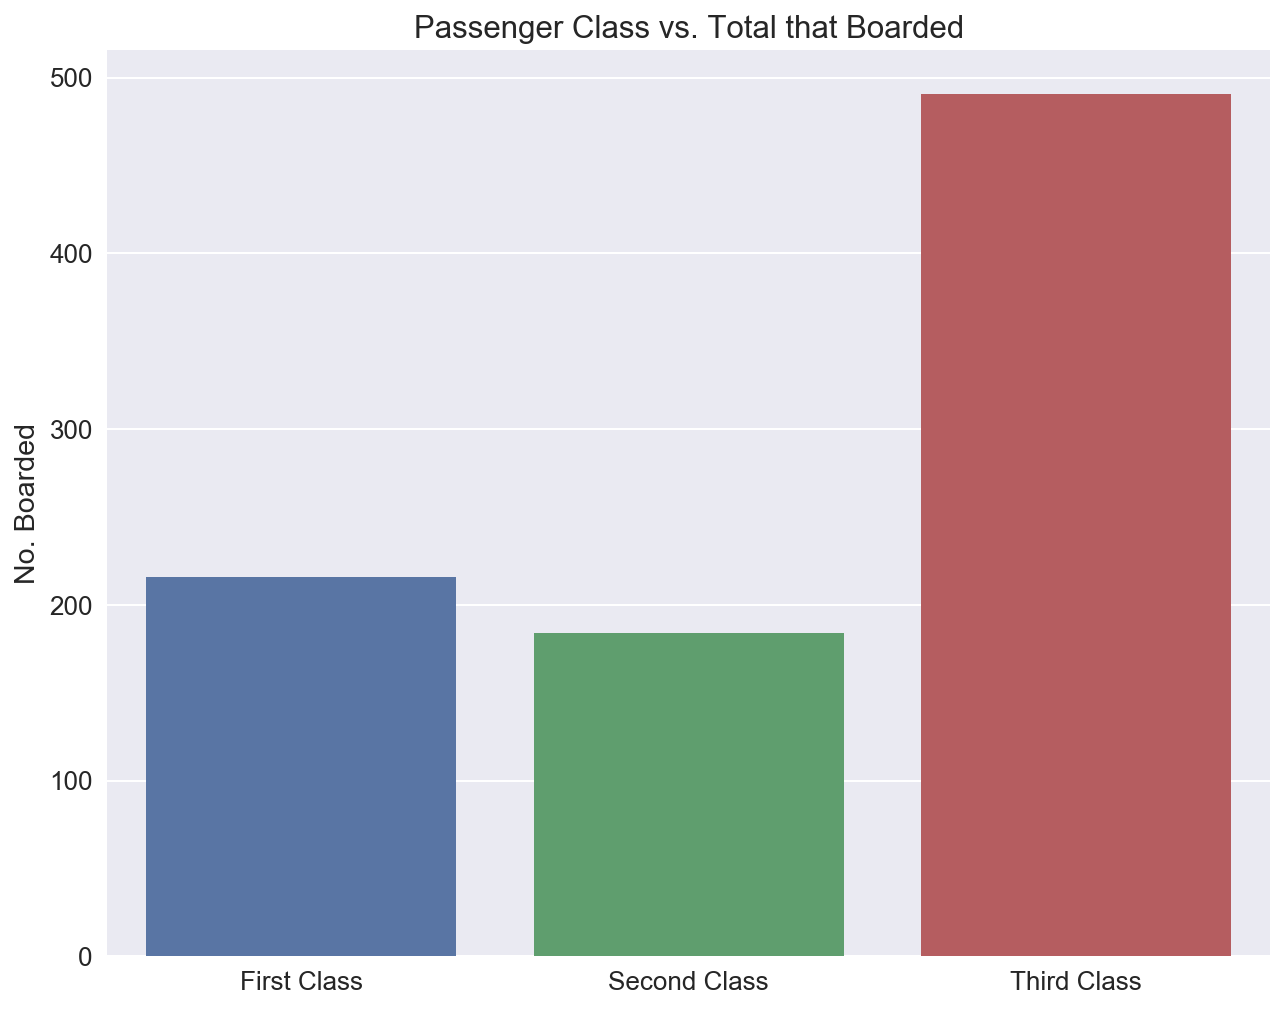

In [134]:
n_firstclass_total = train[(train['Pclass_1'] == 1)].Pclass_1.sum()
n_secondclass_total = train[(train['Pclass_2'] == 1)].Pclass_2.sum()
n_thirdclass_total = train[(train['Pclass_3'] == 1)].Pclass_3.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['First Class', 'Second Class', 'Third Class'], 
            y=[n_firstclass_total, n_secondclass_total, n_thirdclass_total]) 
plt.title('Passenger Class vs. Total that Boarded')
plt.ylabel('No. Boarded')
plt.show()

In [135]:
print('Percent of First Class that Survived: ', n_firstclass_survived / n_firstclass_total)
print('Percent of Second Class that Survived: ', n_secondclass_survived / n_secondclass_total)
print('Percent of Third Class that Survived: ', n_thirdclass_survived / n_thirdclass_total)

Percent of First Class that Survived:  0.6296296296296297
Percent of Second Class that Survived:  0.47282608695652173
Percent of Third Class that Survived:  0.24236252545824846


# Modeling

- **Logistic Regression**

Hyper-parameters: 

C = [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2]

penalty = ['l1', 'l2']                

- **Support Vector Machine**

Hyper-parameters: 

C = [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2]

kernel = ['linear', 'poly', 'rbf']

degree = [2, 3, 4]

- **K-Nearest Neighbors**

Hyper-parameters: 

n_neighbors = [2...15]


- **Gaussian Naive Bayes**

- **Decision Tree Classifier**

Hyper-parameters:

criterion = ['entropy']

max_depth = [2...10]

min_samples_split = [2...10]

After fitting the above, I will then use VotingClassifier, which is used for ensemble learning.

Error Metric: Accuracy

### Splitting Training Data

In [136]:
X = train.iloc[:, 1:]
y = train.Survived

In [137]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25)

### Logistic Regression

In [138]:
C_list = [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2]
penalty_list = ['l1', 'l2']
logreg_params = {'C': C_list, 'penalty': penalty_list}

logreg = LogisticRegression()

logreg_grid = GridSearchCV(logreg, logreg_params, cv=10, scoring='accuracy')
logreg_grid.fit(X_train_val, y_train_val)
preds = logreg_grid.predict(X_test)
acc = accuracy_score(preds, y_test)

In [139]:
logreg_grid.best_estimator_

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [140]:
logreg_grid.best_score_

0.8293413173652695

In [141]:
logreg_grid.best_params_

{'C': 2, 'penalty': 'l1'}

In [142]:
print('Logistic Regression Accuracy: ', acc)

Logistic Regression Accuracy:  0.8340807174887892


### SVM

In [ ]:
kernel_list = ['linear', 'poly', 'rbf']
degree_list = [2, 3, 4, 5]
svc_params = {'C': C_list, 'kernel': kernel_list, 'degree': degree_list}

svc_grid = SVC()

svc_grid = GridSearchCV(svc_grid, svc_params, cv=10, scoring='accuracy')
svc_grid.fit(X_train_val, y_train_val)
preds = svc_grid.predict(X_test)
acc = accuracy_score(preds, y_test)

In [ ]:
svc_grid.best_estimator_

In [ ]:
svc_grid.best_score_

In [ ]:
svc_grid.best_params_

In [ ]:
print('SVM Accuracy: ', acc)

### K-Nearest Neighbors

In [ ]:
n_neighbors_list=np.arange(1, 15, 1)
knn_params = {'n_neighbors': n_neighbors_list}

knn_grid = KNeighborsClassifier()

knn_grid = GridSearchCV(knn_grid, knn_params, cv=10, scoring='accuracy')
knn_grid.fit(X_train_val, y_train_val)
preds = knn_grid.predict(X_test)
acc = accuracy_score(preds, y_test)

In [ ]:
knn_grid.best_estimator_

In [ ]:
knn_grid.best_score_

In [ ]:
knn_grid.best_params_

In [ ]:
print('K-Nearest Neighbors Accuracy: ', acc)

### Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()
train_accs = []
val_accs = []
kf = KFold(n_splits=10)

for train_i, val_i in kf.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_i], X_train_val.iloc[val_i]
    y_train, y_val = y_train_val[train_i], y_train_val[val_i]
    
    gnb.fit(X_train, y_train)
    
    train_preds = gnb.predict(X_train)
    train_accs.append(accuracy_score(train_preds, y_train))
    
    val_preds = gnb.predict(X_val)
    val_accs.append(accuracy_score(val_preds, y_val))

### Decision Tree Classifier

In [ ]:
criterion_list = ['gini', 'entropy']
max_depth_list = np.arange(1, 15, 1)
min_samples_split_list = np.arange(1, 15, 1)

dt_params = {'criterion': criterion_list, 'max_depth_list': max_depth_list, 
             'min_samples_split': min_samples_split_list}

dt_grid = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt_grid, dt_params, cv=10, scoring='accuracy')

dt_grid.fit(X_train_val, y_train_val)
preds = dt_grid.predict(X_test)
acc = accuracy_score(preds, y_test)

In [ ]:
dt_grid.best_estimator_

In [ ]:
dt_grid.best_score_

In [ ]:
dt_grid.best_params_

In [ ]:
print('Decision Tree Classifier Accuracy: ', acc)

### VotingClassifier

In [ ]:
voting_clf = VotingClassifier(estimators=[
    ('logreg_grid', logreg_grid),
    ('svc_grid', svc_grid),
    ('knn_grid', knn_grid),
    ('gnb', gnb),
    ('dt_grid', dt_grid)
], voting='soft').fit(X_train_val, y_train_val)

In [ ]:
preds = voting_clf.predict(X_test)
acc = accuracy_score(preds, y_test)

In [ ]:
print('Voting Classifier Accuracy: ', acc)

# Submitting Test Predictions

In [ ]:
passengerId = test.PassengerId
test.drop('PassengerId')
submission = pd.DataFrame({
    'PassengerId': test.PassengerId
})
test_pred = voting_clf.predict(test)